As an artificial (not very realistic and simplified) example, we consider two buildings: A and B which both have two rooms, respectively (A1, A2, B1 and B2). A is poorly insulated, while B is good insulated. Both buildings are heated using supply water from a common boiler, with hot water first led through building A and then through building B. Since the supply temperature drops along the pipe, the heating efficiency decreases. We assume only two sources that affect the indoor temperature $y_t$ at discretized time step $t \in \{0, \ldots, N\}$: the outdoor temperature $x_t$ and the power of the boiler $p_t$. In this example, we will always have $p_t=1$, why we will be omitted in following equations. The (discretized) dynamics of the indoor temperature for room $r \in \{1,2\}$ and building $b \in \{A,B\}$ is
$$y_{t,b,r} = y_{t - 1, b, r} + x_{t} k_{b} + m_{b,r} + \epsilon.$$
Hence, $k_b$ denotes the degree of insulation and $m_{b,r}$ denotes the heating efficiency. The noise is distributed as  $\epsilon \sim \mathcal{N}(0,0.1)$, and the (true) parameter values we will use are
$$k_{A}=1,\ k_{B}=0.3,\ m_{A,1}=1,\ m_{A,2}=0.7,\ m_{B,1}=0.4,\ m_{B,2}=0.1.$$
The outdoor temperature is generated as
$$x_t = \cos(2\pi t/N) - 1.$$
We start by creating the data frame:

In [73]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

def rng(seed=100): return default_rng(seed)

N = 24

heating_power = np.repeat(1, N)
outdoor_temperature = np.cos(np.linspace(0, 2 * np.pi, N)) - 1 + rng(10).normal(0,.5, N)
time = pd.date_range("2018-01-01 12:00:00", tz='utc', periods=N, freq="H")

df = pd.DataFrame({'building': np.repeat(['a', 'b'], 2 * N),
                   'room': np.repeat(['a1', 'a2', 'b1', 'b2'], N),
                   'time': np.tile(time, 4),
                   'heating_power': np.tile(heating_power, 4),
                   'outdoor_temperature': np.tile(outdoor_temperature, 4),
                   'indoor_temperature': 20
                   })
noise_level = 1e-1
df.loc[df['room'] == 'a1', 'indoor_temperature'] += (
        heating_power * 1 + outdoor_temperature * 1 + rng().normal(0, noise_level, N)).cumsum()
df.loc[df['room'] == 'a2', 'indoor_temperature'] += (
        heating_power * .7 + outdoor_temperature * 1 + rng().normal(0, noise_level, N)).cumsum()
df.loc[df['room'] == 'b1', 'indoor_temperature'] += (
        heating_power * .4 + outdoor_temperature * .3 + rng().normal(0, noise_level, N)).cumsum()
df.loc[df['room'] == 'b2', 'indoor_temperature'] += (
        heating_power * .1 + outdoor_temperature * .3 + rng().normal(0, noise_level, N)).cumsum()

df['y'] = df.groupby('room')['indoor_temperature'].diff()

Let's visualize the simulated temperatures:

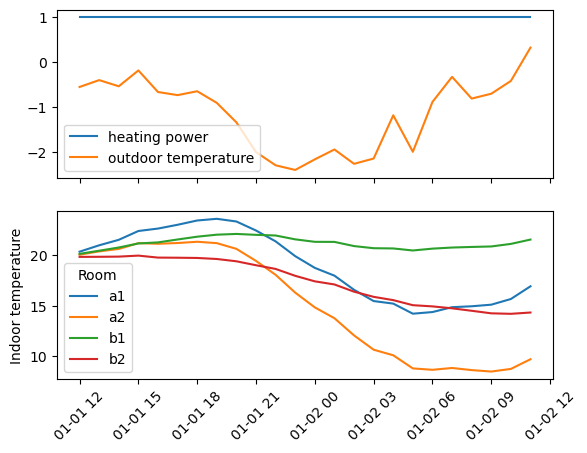

In [74]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(time, heating_power, label='heating power')
axes[0].plot(time, outdoor_temperature, label='outdoor temperature')
axes[0].legend()

for room in ['a1', 'a2', 'b1', 'b2']:
    axes[1].plot(df.loc[df['room'] == room, 'time'], df.loc[df['room'] == room, 'indoor_temperature'], label=room)
axes[1].legend(title='Room')
axes[1].set_ylabel('Indoor temperature')
plt.xticks(rotation=45)
plt.show()

We will consider regression problem of one time step ahead, but with only access to a sample of the data:

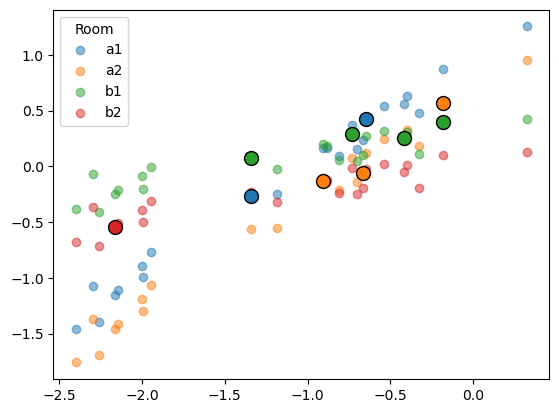

In [88]:
import matplotlib.pyplot as plt

df['y'] = df.groupby('room')['indoor_temperature'].diff()
sample_df = df.dropna().sample(n=10, random_state=16)

for k, g in df.groupby('room'):
    plt.scatter(g['outdoor_temperature'], g['y'], label=k, alpha=.5)
plt.gca().set_prop_cycle(None)
for k, g in sample_df.groupby('room'):
    plt.scatter(g['outdoor_temperature'], g['y'], s=100, linewidths=1, edgecolors='k')
plt.legend(title='Room')
plt.show()

Now, we define our hierarchical model. Suppose we know there is a variation in the degree of insulation for different buildings, why a one-level hierarchy should be applicable for the slope. For the heating power, rooms in the same buildings may vary slightly, and variation between different buildings is even larger. Therefore, we assume a two-level hierarchy for the intercept. The (prior) model we assume is then:

$K_{b} \sim \mathcal{N}(\mu_{\text{k}}, \sigma_{\text{k}}),$
\
$\mu_{\text{k}} \sim \mathcal{N}(0, 1),\ \sigma_{\text{k}} \sim Exp(\exp(\lambda_{\text{k}})),\ \lambda_{\text{k}} \sim \mathcal{N}(0,1)$
\
$M_{b, r} \sim \mathcal{N}(\mu_{\text{m}, b}, \sigma_{\text{m}})$
\
$ \mu_{\text{m}, b} \sim \mathcal{N}(\mu_{\text{m global}}, \sigma_{\text{m global}})$
\
$ \mu_{\text{m global}} \sim \mathcal{N}(0,1) ,\ \sigma_{\text{m global}} \sim Exp(\exp(\lambda_{\text{m global}})) ,\ \lambda_{\text{m global}} \sim \mathcal{N}(0,1)$


We then specify our likelihood as
\
$Y_{t,b,r} - Y_{t - 1, b, r} = x_{t-1} K_{b} + M_{b,r} + \mathcal{N}(0, \sigma_{\text{err}}),\ \sigma_{\text{err}} \sim Exp(10)$

Formulating and doing inference from this model is done by

In [89]:
import pymc as pm
from sakkara.model.components import Distribution
from sakkara.model.utils import Likelihood, data_components, build

coeff = Distribution(pm.Normal,
                     name='outdoor_temperature',
                     column='building',
                     mu=Distribution(
                         pm.Normal
                     ),
                     sigma=Distribution(
                         pm.Exponential,
                         lam=Distribution(pm.Lognormal)
                     )
                     )

intercept = Distribution(pm.Normal,
                         name='heating_power',
                         column='room',
                         mu=Distribution(
                             pm.Normal,
                             column='building',
                             mu=Distribution(pm.Normal),
                             sigma=Distribution(pm.Exponential, lam=Distribution(pm.Lognormal))
                         ),
                         sigma=Distribution(pm.Exponential, lam=Distribution(pm.Lognormal))
                         )

data = data_components(sample_df)

likelihood = Likelihood(pm.Normal,
                        mu=coeff * data['outdoor_temperature'] + intercept,
                        sigma=Distribution(pm.Exponential, lam=10),
                        data=data['y'])
approx = pm.fit(n=100000, method='fullrank_advi', model=build(sample_df, likelihood))

Finished [100%]: Average Loss = 8.1609


Let's find out what has been learnt! We start with mean from the summary dataframe, showing we are doing fairly well despite the limited data:

In [90]:
import arviz as az

summary = az.summary(approx.sample(10000))
print(summary.loc[:, 'mean'])

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


mu_outdoor_temperature           0.530
outdoor_temperature[b]           0.347
outdoor_temperature[a]           0.903
mu_mu_heating_power              0.501
mu_heating_power[b]              0.402
mu_heating_power[a]              0.735
heating_power[b2]                0.229
heating_power[a2]                0.657
heating_power[b1]                0.484
heating_power[a1]                0.956
lam_sigma_outdoor_temperature    1.640
sigma_outdoor_temperature        0.668
lam_sigma_mu_heating_power       1.900
sigma_mu_heating_power           0.525
lam_sigma_heating_power          2.139
sigma_heating_power              0.330
sigma_likelihood                 0.116
Name: mean, dtype: float64


By then inspecting the (conditional) posterior predictive distribution, we can get a better feel for the uncertainties involved here.

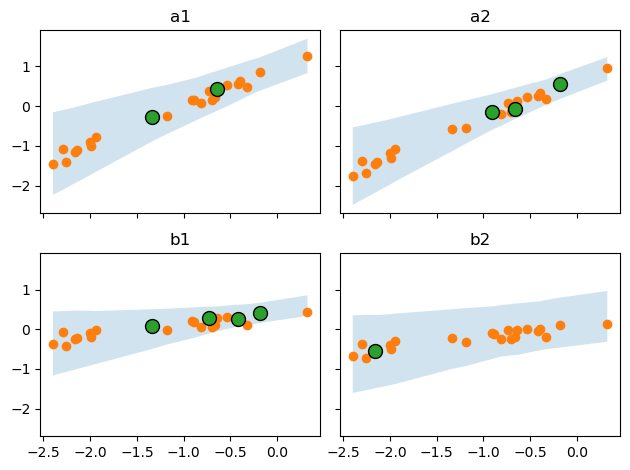

In [91]:
intercepts = approx.sample(1000).posterior['heating_power'].to_dataframe()
coeffs = approx.sample(1000).posterior['outdoor_temperature'].to_dataframe()

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

for ax, (k, room_df), (_, room_sample) in zip(axes.flatten(), df.groupby('room'), sample_df.groupby('room')):
    room = k
    building = k[0]

    room_intercepts = intercepts.loc[:, :, room].values.flatten()

    room_coeffs = coeffs.loc[:, :, building].values.flatten()

    room_df = room_df.sort_values(by='outdoor_temperature')
    y_min = pd.Series(index=room_df.index, dtype=float)
    y_max = pd.Series(index=room_df.index, dtype=float)
    for i, out_temp in room_df.loc[:, 'outdoor_temperature'].items():
        y = out_temp * room_coeffs + room_intercepts
        y_min[i] = np.percentile(y, 1)
        y_max[i] = np.percentile(y, 99)
    ax.fill_between(room_df['outdoor_temperature'], y_min, y_max, alpha=.2)
    ax.scatter(room_df['outdoor_temperature'], room_df['y'])
    ax.scatter(room_sample['outdoor_temperature'], room_sample['y'], s=100, linewidths=1, edgecolors='k')
    ax.set_title(room)

plt.tight_layout()
plt.show()

These uncertainties are also manifested when predicting the indoor temperature forward in time.

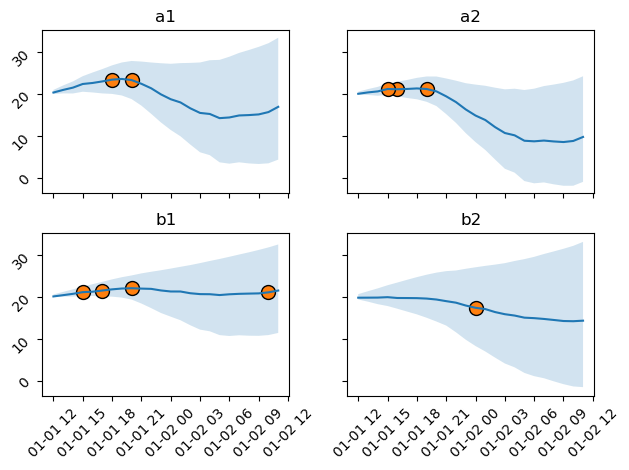

In [92]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

for ax, (k, room_df), (_, room_sample) in zip(axes.flatten(), df.groupby('room'), sample_df.groupby('room')):
    room = k
    building = k[0]

    room_intercepts = intercepts.loc[:, :, room].values.flatten()

    room_coeffs = coeffs.loc[:, :, building].values.flatten()

    room_df = room_df.sort_values(by='time')

    temp_diff = room_df.loc[:, 'outdoor_temperature'].map(lambda x: x * room_coeffs + room_intercepts)
    temp_diff = 20 + pd.DataFrame.from_dict(dict(zip(temp_diff.index, temp_diff.values))).cumsum(axis=1)
    
    ax.fill_between(room_df.time, np.percentile(temp_diff, 1, axis=0), np.percentile(temp_diff, 99, axis=0), alpha=.2)
    
    ax.plot(room_df.time, room_df.indoor_temperature)
    ax.scatter(room_sample.time, room_sample.indoor_temperature, s=100, linewidths=1, edgecolors='k')
    ax.set_title(room)
    ax.tick_params(labelrotation=45)
    
plt.tight_layout()
plt.show()
